# Testing the different types of scalers with logistic regression

- The code has been quasi pipelined so that changes to the functions can be run more easily and done in more modularized ways.

- The model has been shown to work best with logistic regression from cuml so this file should be moved over to linux and run on a computer with nvidia CUDA capabilities once the feature engineering testing is done.

- COLAB kicked me off for using too much of their cloud GPU resources :'(
---

In [1]:
#########
# TO DO #
#################################################################
# after the yeo-johnson transformation on the numerical data    #
# one hot encode the categorical features                       #
# recombine the data so and run standarscaler                   #
#################################################################
# It looks like the yeo johnson transform is done column-wise   #
# Put the data in two long lists for the g- and c- features     #
# Perform yeo johnson on each                                   #
# put the data back into the df                                 #
#################################################################

In [2]:
import io, requests

import datetime
import pandas as pd
import numpy as np
from time import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.preprocessing import power_transform
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import NuSVR
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.metrics import log_loss

from imblearn.under_sampling import TomekLinks
# from imblearn.under_sampling import ClusterCentroids
# from imblearn.under_sampling import NeighbourhoodCleaningRule # made model marginally worse and took significantly longer
# from imblearn.under_sampling import InstanceHardnessThreshold #kept getting errors
# from imblearn.under_sampling import EditedNearestNeighbours#did not remove any samples
# from imblearn.under_sampling import AllKNN#did not remove any samples
# from imblearn.under_sampling import CondensedNearestNeighbour#crashed after using all ram
# from imblearn.under_sampling import NearMiss# marginally worse after running NearMiss(version=2, n_jobs=2, sampling_strategy=sampling_val)

# Loading / Processing the Data

---

## Loading the data and some initial preprocessing

In [3]:
def dummy_vars(df):
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    # trt_cp is a control and has no MOA, ctl_vehicle indicates a real test
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
    # create columns ['cp_type_24', 'cp_type_48', 'cp_type_72'] which are one hot encoded based on cp_time
    df['cp_type_24'] = df['cp_time'].astype(str) == '24'
    df['cp_type_48'] = df['cp_time'].astype(str) == '48'
    df['cp_type_72'] = df['cp_time'].astype(str) == '72'
    df.drop(columns=['sig_id','cp_time'], inplace = True)
    return df

In [4]:
def load_files():
    # Train Features
    train_features = pd.read_csv('train_features.csv')
    train_features = dummy_vars(train_features)
    print('train_features loaded')

    # Train Targets
    train_targets = pd.read_csv('train_targets_scored.csv')
    train_targets.drop(columns=['sig_id'], inplace = True)
    print('train_targets loaded')

    # Test Features
    test_features = pd.read_csv('test_features.csv')
    test_features = dummy_vars(test_features)
    #test_features = pd.DataFrame(power_transform(test_features, method='yeo-johnson'))
    print('test_features loaded')

    # Sample Submission DF (Targets)
    ss_lr = pd.read_csv('sample_submission.csv')
    ss_lr.drop(columns=['sig_id'], inplace = True)
    print('ss_lr loaded')

    print('done!')

    return train_features, train_targets, test_features, ss_lr

In [5]:
def log_loss_metric(y_true, y_pred):
    metrics = []
    for _target in train_targets.columns:
        metrics.append(log_loss(y_true.loc[:, _target], y_pred.loc[:, _target].astype(float), labels = [0,1]))
    return np.mean(metrics)

## split and train for each model

In [6]:
def k_fold_log_reg(model_train_num, column, x_test, target_vals, N_SPLITS):
  for rand_state in range(model_train_num):
  # train the model for each one of the random states 
    skf = StratifiedKFold(n_splits = N_SPLITS, random_state = rand_state, shuffle = True)

    for (train, val) in skf.split(target_vals, target_vals):
    # for each of the train/validate splits...

      x_train = X[train, column].reshape(-1, 1).astype(float)
      y_train = target_vals[train].astype(float)
     
      model.fit(x_train, y_train)

      x_val = X[val, column].reshape(-1, 1).astype(float)
      y_val = target_vals[val].astype(float)

      #ss_pred_vals = cp.asnumpy(model.predict_proba(x_test[:, column].reshape(-1, 1).astype(float))[:, 1])
      ss_pred_vals = model.predict(x_test[:, column].reshape(-1,1))
      ss_lr.loc[:, train_targets.columns[column]] += (
        ss_pred_vals / (N_SPLITS * model_train_num))

      #res_pred_vals = cp.asnumpy(model.predict_proba(x_val)[:, 1].astype(float))
      res_pred_vals = model.predict(x_val)
      res_lr.loc[val, train_targets.columns[column]] += (
        res_pred_vals / model_train_num)

In [7]:
# cols = [c for c in ss_lr.columns.values]
def run_score(train_targets, X, x_test, ss_lr, logloss_vals):
# train_targets is the training targets
# X is the train features
# x_test is the holdout set of features
# ss_lr is blank since it's the empty sample submission predictions

  N_SPLITS = 5 # number of k-fold splits
  model_train_num = 2 # number of random states the model is trained on for each target

  for column in tqdm(range(train_targets.shape[1])):
  # create a model for each of the targets
      start_time = time()
      target_vals = train_targets.values[:, column]

      if target_vals.sum() >= 5:
        # split if there's enough positive target values
        k_fold_log_reg(model_train_num, column, x_test, target_vals, N_SPLITS)

      score = log_loss(
       train_targets.loc[:, train_targets.columns[column]],
       res_lr.loc[:, train_targets.columns[column]]
       )
      feat_time = str(datetime.timedelta(seconds = time() - start_time))[2:7]
      #print(f'[{feat_time}] Target {column+1}/{train_targets.shape[1]} Log Loss:', score)
      target_counts.append(np.sum(target_vals))
      logloss_vals.append(score)

  print(f'Log Loss: {log_loss_metric(train_targets, res_lr)}')

  # these lines automatically set the target values equal to zero if it cp_type = 1 AKA control group  
  res_lr.loc[train_features['cp_type'] == 1, train_targets.columns] = 0
  ss_lr.loc[test_features['cp_type'] == 1, train_targets.columns] = 0
  print(f'After manually eliminating control groups: {log_loss_metric(train_targets, res_lr)}\n\n')
  #print(f'lrg_target_sum = {lrg_target_sum}\nsml_target_sum = {sml_target_sum}\none_target_sum = {one_target_sum}')


In [8]:
train_features, train_targets, test_features, ss_lr = load_files()

g_tags = [g for g in list(train_features.columns) if g[0]+g[1] == 'g-']
c_tags = [c for c in list(train_features.columns) if c[0]+c[1] == 'c-']

scaler = StandardScaler()
train_features[c_tags] = scaler.fit_transform(train_features[c_tags])
test_features[c_tags] = scaler.fit_transform(test_features[c_tags])

scaler = StandardScaler()
train_features[g_tags] = scaler.fit_transform(train_features[g_tags])
test_features[g_tags] = scaler.fit_transform(test_features[g_tags])

#X = scaler.fit_transform(train_features.values[:, top_feats])
X = train_features.values[:,:]

#x_test = scaler.transform(test_features.values[:, top_feats])
x_test = test_features.values[:,:]

#This is for the sample_submission.csv df
ss_lr.loc[:, train_targets.columns] = 0

#These are the target values which are being predicted and tested
res_lr = train_targets.copy()
res_lr.loc[:, train_targets.columns] = 0

cols = ss_lr.columns.values

train_features loaded
train_targets loaded
test_features loaded
ss_lr loaded
done!


In [9]:
#model = SVR(kernel='poly', gamma='auto', C=200, cache_size=14000) #had estimated finish time of 12 hrs
#model = SVR(kernel='rbf', gamma='scale', C=10, epsilon=0.1)# slooowwwww
#model = NuSVR(C=1, nu=0.1) # The default kernel is RBF
#model = LogisticRegression(C = 128, max_iter = 100000) #128 is the ideal value for cuml using standard scaler
#model = SKLogisticRegression(C = 128, solver = 'lbfgs', warm_start=True, n_jobs=-1 max_iter = 10000)

#for i in np.float_power(2,list(range(1,5))):
for i in [1]:
  model = SKLogisticRegression(C = i, solver = 'lbfgs', warm_start=True, n_jobs=-1, max_iter = 10000)
  target_counts = []
  logistic_regr_logloss_vals = []
  ss_lr.loc[:, train_targets.columns] = 0
  res_lr.loc[:, train_targets.columns] = 0
  print(f'C = {i}')
  run_score(train_targets, X, x_test, ss_lr, logistic_regr_logloss_vals)
plt.scatter(target_counts,logistic_regr_logloss_vals)
plt.xlabel('target_counts')
plt.ylabel('log loss values')
plt.title('SKLearn Logistic Regression')
plt.show()

C = 1



Log Loss: 0.11807970883421855
After manually eliminating control groups: 0.11807970883421855





Log Loss: 0.020577889995645235
After manually eliminating control groups: 0.020318656220813875




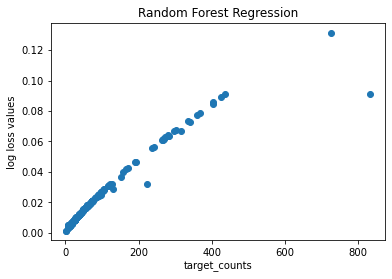

In [10]:

model = RandomForestRegressor(max_depth=3, random_state=42)

for i in [1]:
  target_counts = []
  rand_forest_logloss_vals = []
  ss_lr.loc[:, train_targets.columns] = 0
  res_lr.loc[:, train_targets.columns] = 0
  run_score(train_targets, X, x_test, ss_lr, rand_forest_logloss_vals)
  plt.scatter(target_counts,rand_forest_logloss_vals)
  plt.xlabel('target_counts')
  plt.ylabel('log loss values')
  plt.title('Random Forest Regression')
  plt.show()

intercept_scaling = 1



Log Loss: 0.020862034953362217
After manually eliminating control groups: 0.020591874839540725




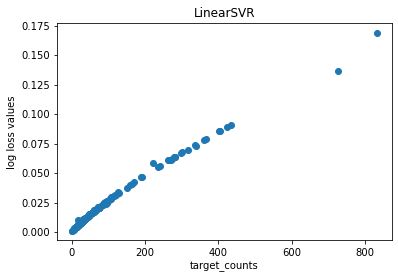

In [25]:
from sklearn.svm import LinearSVR
for i in [1]:
  model = LinearSVR(random_state = 42, C=16, dual=False, loss='squared_epsilon_insensitive', tol=1e-5)
  target_counts = []
  linsvr_logloss_vals = []
  ss_lr.loc[:, train_targets.columns] = 0
  res_lr.loc[:, train_targets.columns] = 0
  print(f'intercept_scaling = {i}')
  run_score(train_targets, X, x_test, ss_lr, linsvr_logloss_vals)
plt.scatter(target_counts,linsvr_logloss_vals)
plt.xlabel('target_counts')
plt.ylabel('log loss values')
plt.title('LinearSVR')
plt.show()

ogloss:0.08023
[9]	eval-logloss:0.07705	train-logloss:0.07442
[0]	eval-logloss:0.45103	train-logloss:0.45085
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 5 rounds.
[1]	eval-logloss:0.31808	train-logloss:0.31777
[2]	eval-logloss:0.23543	train-logloss:0.23493
[3]	eval-logloss:0.18111	train-logloss:0.18045
[4]	eval-logloss:0.14456	train-logloss:0.14361
[5]	eval-logloss:0.11963	train-logloss:0.11833
[6]	eval-logloss:0.10246	train-logloss:0.10087
[7]	eval-logloss:0.09076	train-logloss:0.08872
[8]	eval-logloss:0.08271	train-logloss:0.08040
[9]	eval-logloss:0.07736	train-logloss:0.07458
[0]	eval-logloss:0.45088	train-logloss:0.45093
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 5 rounds.
[1]	eval-logloss:0.31784	train-logloss:0.31790
[2]	eval-logloss:0.23497	train-logloss:0.23511
[3]	eval-logloss:0.18063	tr

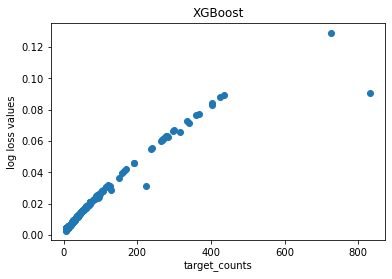

In [11]:
target_counts = []
xgb_logloss_vals = []

N_SPLITS = 5 # number of k-fold splits
model_train_num = 2 # number of random states the model is trained on for each target

#XGB Parameters
param = {'max_depth': 6, 'eta': 0.3, 'objective': 'binary:logistic'}
param['verbosity'] = 0 #increase if errors
param['eval_metric'] = 'logloss'

num_round = 10

for column in tqdm(range(train_targets.shape[1])):
# create a model for each of the targets
    start_time = time()
    target_vals = train_targets.values[:, column]

    if target_vals.sum() >= 5:
        skf = StratifiedKFold(n_splits = N_SPLITS, random_state = 42, shuffle = True)

        for (train, val) in skf.split(target_vals, target_vals):
            # for each of the train/validate splits...

            x_train = X[train, column].reshape(-1, 1).astype(float)
            y_train = target_vals[train].astype(float)

            x_val = X[val, column].reshape(-1, 1).astype(float)
            y_val = target_vals[val].astype(float)      
            
            dtrain = xgb.DMatrix(x_train, label=y_train)
            dval = xgb.DMatrix(x_val, label=y_val)
            evallist = [(dval, 'eval'), (dtrain, 'train')]
            bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=5)
            # look into grow_policy = lossguide (it needs tree_method to be set to hist, but maybe cpu_hist will work too)

        score = log_loss(
            train_targets.loc[:, train_targets.columns[column]],
            res_lr.loc[:, train_targets.columns[column]]
        )
        feat_time = str(datetime.timedelta(seconds = time() - start_time))[2:7]
        #print(f'[{feat_time}] Target {column+1}/{train_targets.shape[1]} Log Loss:', score)
        target_counts.append(np.sum(target_vals))
        xgb_logloss_vals.append(score)

print(f'Log Loss: {log_loss_metric(train_targets, res_lr)}')

# these lines automatically set the target values equal to zero if it cp_type = 1 AKA control group  
res_lr.loc[train_features['cp_type'] == 1, train_targets.columns] = 0
ss_lr.loc[test_features['cp_type'] == 1, train_targets.columns] = 0
print(f'After manually eliminating control groups: {log_loss_metric(train_targets, res_lr)}\n\n')
plt.scatter(target_counts,xgb_logloss_vals)
plt.xlabel('target_counts')
plt.ylabel('log loss values')
plt.title('XGBoost')
plt.show()

In [12]:
zeros_target_counts = []
zeros_logloss_vals = []
res_lr.loc[:, train_targets.columns] = 0
for i in range(res_lr.shape[1]):
  loss = log_loss(train_targets.iloc[:,i], res_lr.iloc[:,i])
  zeros_logloss_vals.append(loss)
  zeros_target_counts.append(np.sum(train_targets.iloc[:,i]))
# log loss score is the same for all zeros or the average values per column

In [18]:
import plotly.express as px
import plotly.graph_objects as go
import plotly
import os

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=zeros_target_counts,
    y=zeros_logloss_vals,
    name='all zeros',
    mode='lines',
    hovertemplate=['' for i in range(len(train_targets.columns))])
)
fig.add_trace(go.Scatter(
    x=target_counts,
    y=rand_forest_logloss_vals,
    name='Random Forest Regression',
    mode='markers',
    hovertemplate = train_targets.columns)
)
fig.add_trace(go.Scatter(
    x=target_counts,
    y=logistic_regr_logloss_vals,
    name='Logistic Regression',
    mode='markers',
    hovertemplate = train_targets.columns)
)
fig.add_trace(go.Scatter(
    x=target_counts,
    y=xgb_logloss_vals,
    name='XGBoost',
    mode='markers',
    hovertemplate = train_targets.columns)
)
fig.add_trace(go.Scatter(
    x=target_counts,
    y=linsvr_logloss_vals,
    name='linSVR',
    mode='markers',
    hovertemplate = train_targets.columns)
)
fig.update_layout(
    title='Model Evaluation',
    xaxis_title='Size of Minority Class (out of 20,000)',
    yaxis_title='Log Loss Score',
    hoverlabel_align = 'right'
)
fig.show()

if not os.path.exists("figures"):
    os.mkdir("figures")
    
the_date = datetime.datetime.now()

html_path = 'figures/Plotly_3d_' + str(the_date) + '.html'
plotly.io.write_html(fig, html_path)

In [127]:
import xgboost as xgb
#train_targets.head()
#train_features.head()

target_counts = []
xgb_logloss_vals = []

N_SPLITS = 5 # number of k-fold splits
model_train_num = 2 # number of random states the model is trained on for each target

#XGB Parameters
param = {'max_depth': 5, 'eta': 0.3, 'objective': 'binary:logistic'}
param['booster'] = 'gblinear'
param['eval_metric'] = 'logloss'

num_round = 10

for column in tqdm(range(train_targets.shape[1])):
# create a model for each of the targets
    start_time = time()
    target_vals = train_targets.values[:, column]

    if target_vals.sum() >= 5:
        skf = StratifiedKFold(n_splits = N_SPLITS, random_state = 42, shuffle = True)

        for (train, val) in skf.split(target_vals, target_vals):
            # for each of the train/validate splits...

            x_train = X[train, column].reshape(-1, 1).astype(float)
            y_train = target_vals[train].astype(float)

            x_train, y_train = undersample.fit_resample(x_train, y_train)

            x_val = X[val, column].reshape(-1, 1).astype(float)
            y_val = target_vals[val].astype(float)      
            
            dtrain = xgb.DMatrix(x_train, label=y_train)
            dval = xgb.DMatrix(x_val, label=y_val)
            evallist = [(dval, 'eval'), (dtrain, 'train')]
            bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=5)

        score = log_loss(
            train_targets.loc[:, train_targets.columns[column]],
            res_lr.loc[:, train_targets.columns[column]]
        )
        feat_time = str(datetime.timedelta(seconds = time() - start_time))[2:7]
        #print(f'[{feat_time}] Target {column+1}/{train_targets.shape[1]} Log Loss:', score)
        target_counts.append(np.sum(target_vals))
        xgb_logloss_vals.append(score)
        
print(f'Log Loss: {log_loss_metric(train_targets, res_lr)}')

# these lines automatically set the target values equal to zero if it cp_type = 1 AKA control group  
res_lr.loc[train_features['cp_type'] == 1, train_targets.columns] = 0
ss_lr.loc[test_features['cp_type'] == 1, train_targets.columns] = 0
print(f'After manually eliminating control groups: {log_loss_metric(train_targets, res_lr)}\n\n')

l-logloss:0.14837	train-logloss:0.14846
[4]	eval-logloss:0.10726	train-logloss:0.10737
[5]	eval-logloss:0.07822	train-logloss:0.07835
[6]	eval-logloss:0.05744	train-logloss:0.05758
[7]	eval-logloss:0.04242	train-logloss:0.04258
[8]	eval-logloss:0.03150	train-logloss:0.03168
[9]	eval-logloss:0.02353	train-logloss:0.02372
[22:47:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	eval-logloss:0.44476	train-logloss:0.44476
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 5 rounds.
[1]	eval-logloss:0.30802	train-logloss:0.30803
[2]	eval-logloss:0.22251	train-logloss:0.22252
[3]	eval-logloss:0.16593	tra

In [ ]:
nss_lr.to_csv('drive/My Drive/Metis/ss_lr.csv')
res_lr.to_csv('drive/My Drive/Metis/res_lr.csv')
